In [175]:
%matplotlib inline

In [55]:

# coding: utf-8

# In[ ]:



# LSTM and CNN for sequence classification in the IMDB dataset
import numpy as np
import scipy as sc
import cv2 as cv2
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow
from PIL import Image
from resizeimage import resizeimage
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.core import Flatten
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
comb_data = h5py.File('/local/viraj/courses/ME592x/assn3/Aditya_data/combustion_img_13.mat','r')
X = comb_data['train_set_x'][()]
y = comb_data['train_set_y'][()]

In [57]:
X_trf, X_tsf,y_trf, y_tsf = train_test_split(X.T, y, test_size=0.2)

In [224]:
#Resizing the image to lower resolution in (width, height): CHANGE THIS PARAMETER FOR DIFFERENT RESOLUTIONS
width = int(128)
height = int(128)
num_features = width*height

In [225]:
a=np.shape(X_trf)[0]
X_train_final = np.zeros([a,num_features])
for i in range(0,a):
    temp_image = X_trf[i,:] 
    temp_image = np.reshape(temp_image,[250,100])
    temp_image = temp_image.T
    temp_image = cv2.resize(temp_image, dsize=((width,height)))
    temp_image = np.reshape(temp_image,[num_features,])
    X_train_final[i,:] = temp_image
    
b = np.shape(X_tsf)[0]
X_test_final = np.zeros([b,num_features])
for i in range(0,b):
    temp_image = X_tsf[i,:] 
    temp_image = np.reshape(temp_image,[250,100])
    temp_image = temp_image.T
    temp_image = cv2.resize(temp_image, dsize=(width,height))
    temp_image = np.reshape(temp_image,[num_features,])
    X_test_final[i,:] = temp_image

In [226]:
#Following two are the hyper-parameters for the model
n_frames = int(20) #n_frames means the stride to use
n_filters = int(6) #number of filters in each ConvLSTM layer

#Fixed parameters
n_channels = int(1)
n_rows = height
n_cols = width
n_train_samples = a/n_frames
n_test_samples = b/n_frames

In [227]:
X_train_final = X_train_final.reshape([n_train_samples,n_frames,n_rows,n_cols,n_channels])
X_test_final =  X_test_final.reshape([n_test_samples,n_frames,n_rows,n_cols,n_channels])

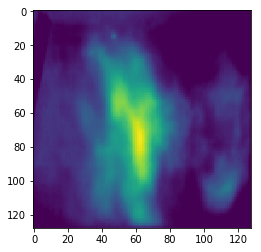

In [228]:
plt.imshow(X_train_final[68,5,:,:,0])

In [229]:
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,MaxPooling2D)
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Reshape

In [230]:
y_train_final = y_trf.reshape((n_train_samples,n_frames,1))
y_test_final = y_tsf.reshape((n_test_samples,n_frames,1))

In [231]:

# fix random seed for reproducibility
np.random.seed(7)

#Convolution

seq = Sequential()
seq.add(ConvLSTM2D(filters=n_filters, kernel_size=(3, 3),
                   input_shape=(None,n_rows,n_cols,1),
                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())
seq.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
seq.add(ConvLSTM2D(filters=n_filters, kernel_size=(3, 3),
                   input_shape=(None,n_rows,n_cols,1),
                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())
seq.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

seq.add(TimeDistributed(Reshape((-1,))))
seq.add(TimeDistributed(Dense(1, activation='sigmoid')))
seq.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(seq.summary())
seq.fit(X_train_final, y_train_final, epochs=1, batch_size=32)
# Final evaluation of the model
scores = seq.evaluate(X_test_final, y_test_final, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_25 (ConvLSTM2D) (None, None, 128, 128, 6) 1536      
_________________________________________________________________
time_distributed_29 (TimeDis (None, None, 64, 64, 6)   0         
_________________________________________________________________
conv_lst_m2d_26 (ConvLSTM2D) (None, None, 64, 64, 6)   2616      
_________________________________________________________________
time_distributed_30 (TimeDis (None, None, 32, 32, 6)   0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, None, 6144)        0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, None, 1)           6145      
Total params: 10,297
Trainable params: 10,297
Non-trainable params: 0
_________________________________________________________________
None
E